A script to fit a SARIMAX model to data of energy consumption from PJM Western Region 2001-2018.
Data available at:
https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?resource=download&select=PJMW_hourly.csv

In [4]:
#Prerequisites

import piplite
await piplite.install("statsmodels")
#await piplite.install("pmdarima") #Can't be installed in jupyter lite, but should be used to find best parameters for SARIMAX model.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Defining function to group into training (85%), test data and full data.
#Also making possible to group data from hours into larger groups such as months.
def get_train_test(freq = None):
    df = pd.read_csv('PJMW_hourly.csv')
    df.index = pd.to_datetime(df['Datetime'])
    df.drop(columns='Datetime',inplace=True)
    df.sort_index(inplace=True)
    if freq is not None:
        df = df[['PJMW_MW']].resample(freq).sum()
    train_percent = 0.85
    train_size = int(train_percent*len(df))
    train_df = df.iloc[:train_size].copy()
    test_df = df.iloc[train_size:].copy()
    return train_df,test_df,df

In [4]:
#Training, test and full dataset
tr_df, te_df, df=get_train_test()

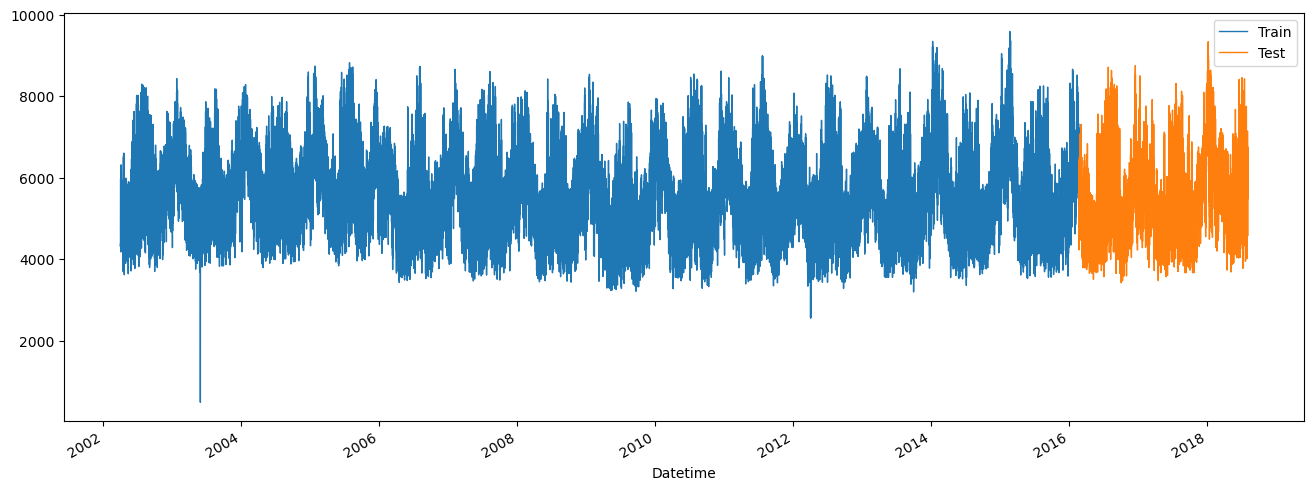

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 16,6
tr_df['PJMW_MW'].plot(label='Train',legend=True,linewidth=1)
te_df['PJMW_MW'].plot(label='Test',legend=True,linewidth=1)

plt.show()

In [6]:
#Plotting function to visualise/analyse seasonality
def plot_consumption(Year=None, Month=None, Week=None, Day = None):
    df.plot(figsize=(15,9),title='Energy Consumption') 
    if Year is not None:
        df.loc[df.index.year == Year].plot(figsize=(15,9),title=f"Data of year {Year}")
    if Month is not None:
        df.loc[(df.index.year == Year) & (df.index.month == Month)].plot(figsize=(15,9),title=f"Data of year {Year}, month {Month}")
    if Week is not None:
        df.loc[(df.index.year == Year) & (df.index.month == Month) & (df.index.isocalendar().week == Week)].plot(figsize=(15,9),title=f"Data of year {Year}, month {Month}, week {Week}")
    if Day is not None:
        df.loc[(df.index.year == Year) & (df.index.month == Month) & (df.index.isocalendar().week == Week) & (df.index.isocalendar().day == Day)].plot(figsize=(15,9),title=f"Data of year {Year}, month {Month}, week {Week}, day {Day}")

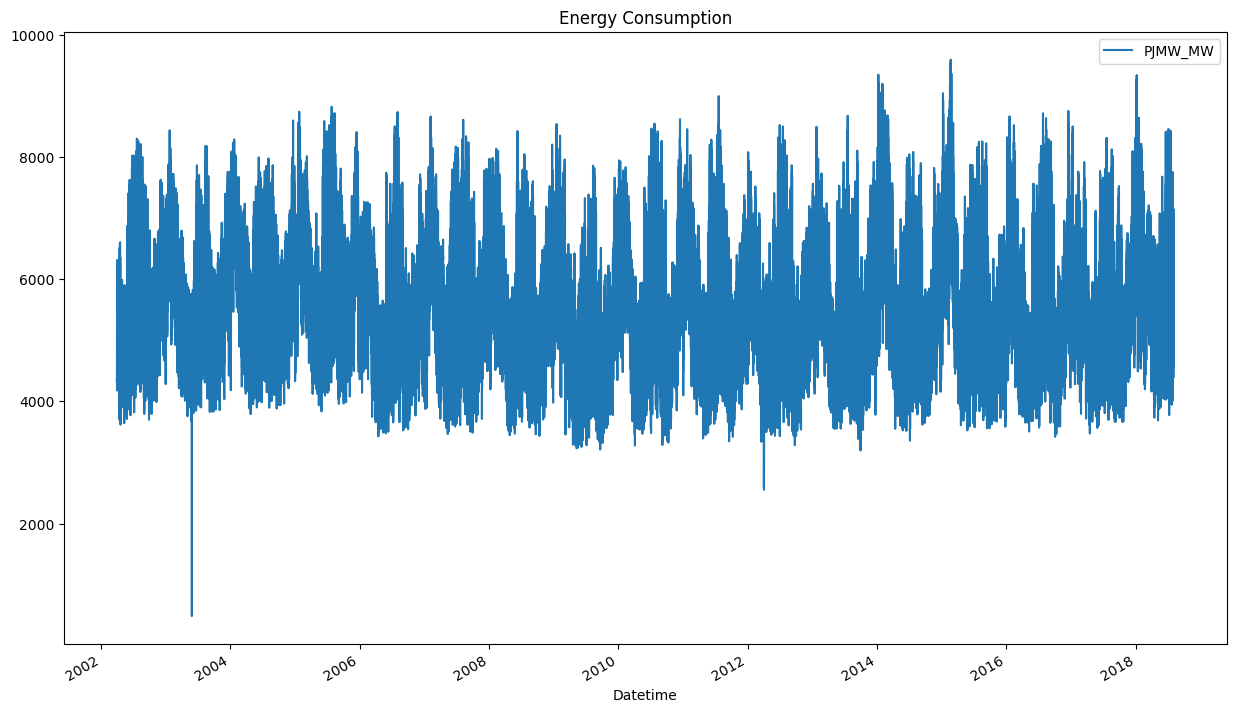

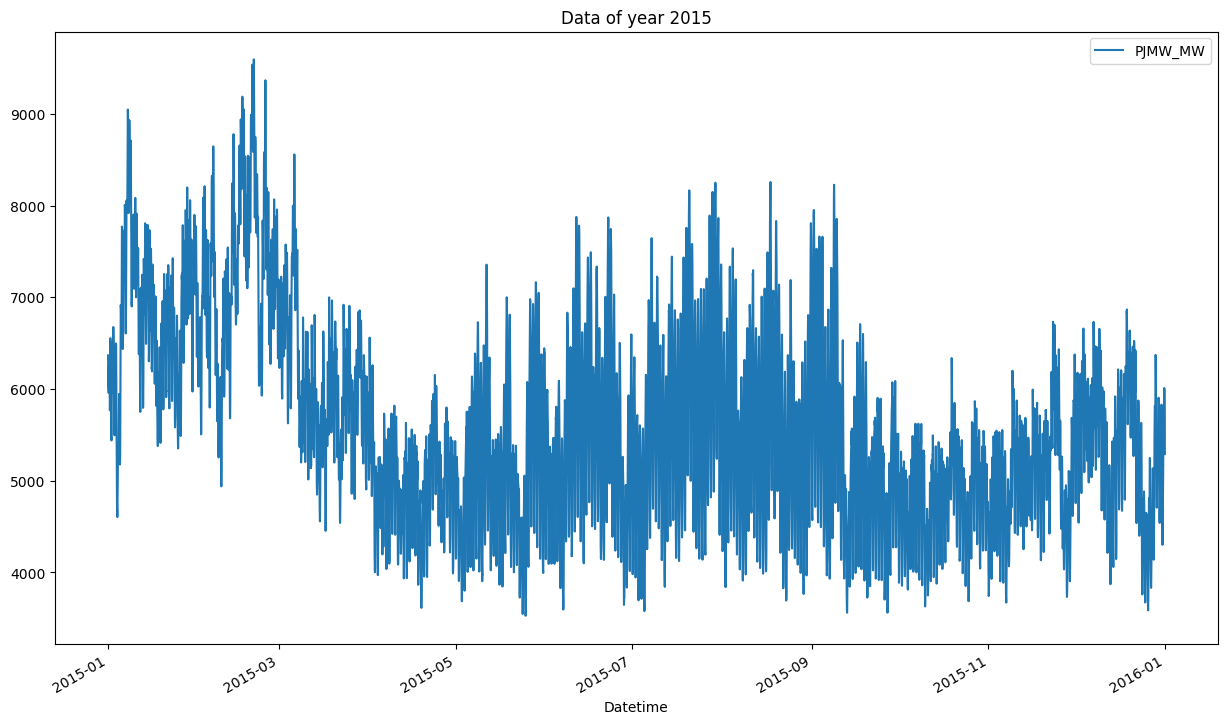

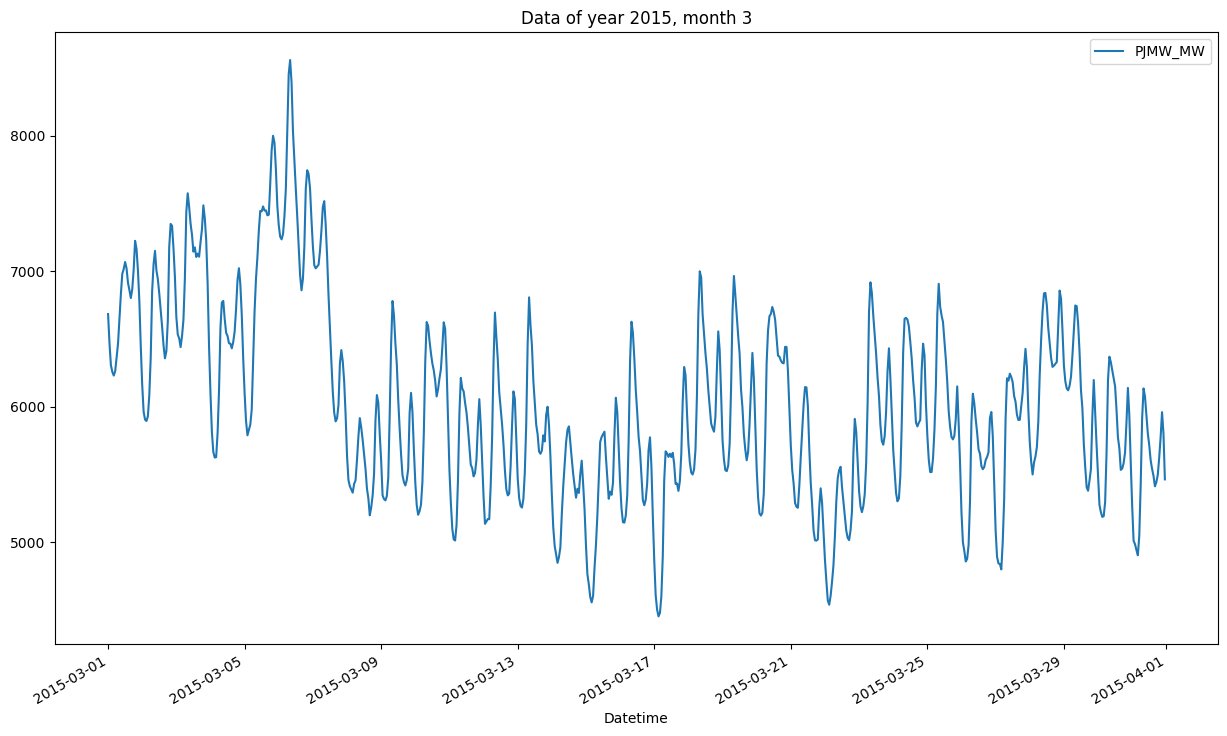

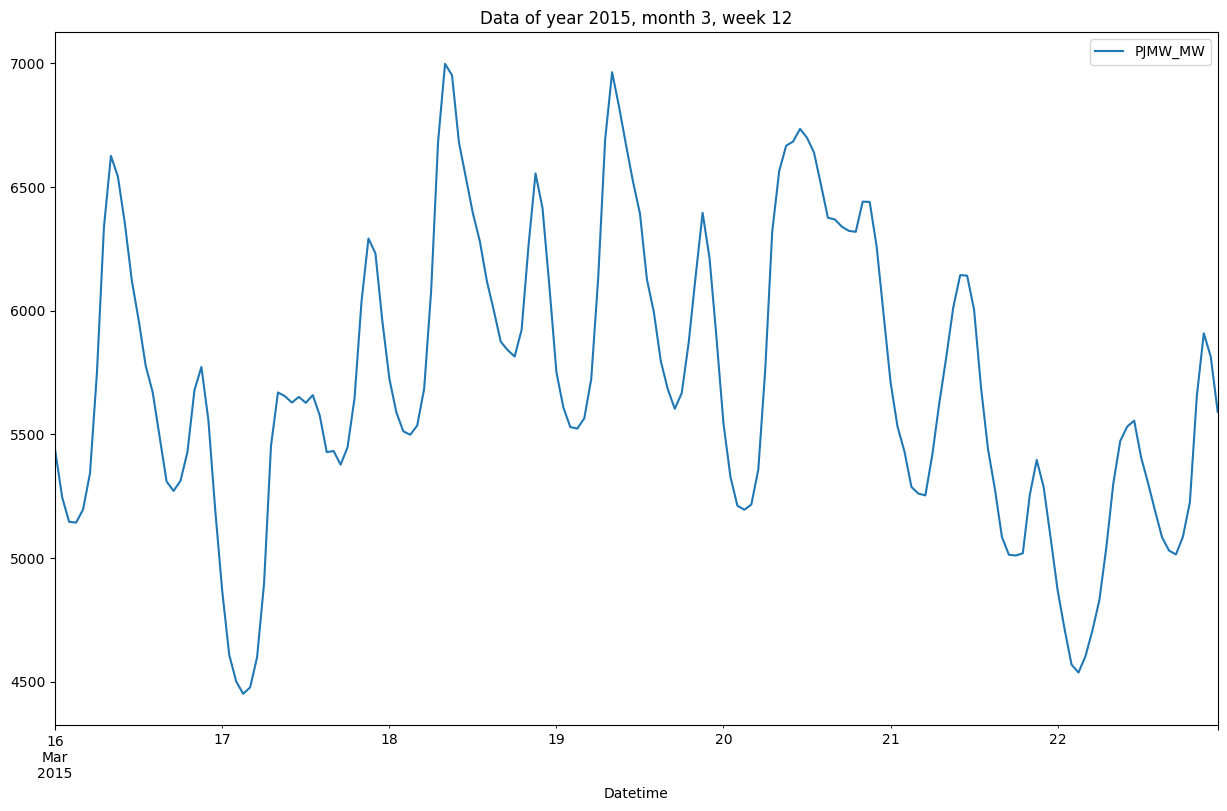

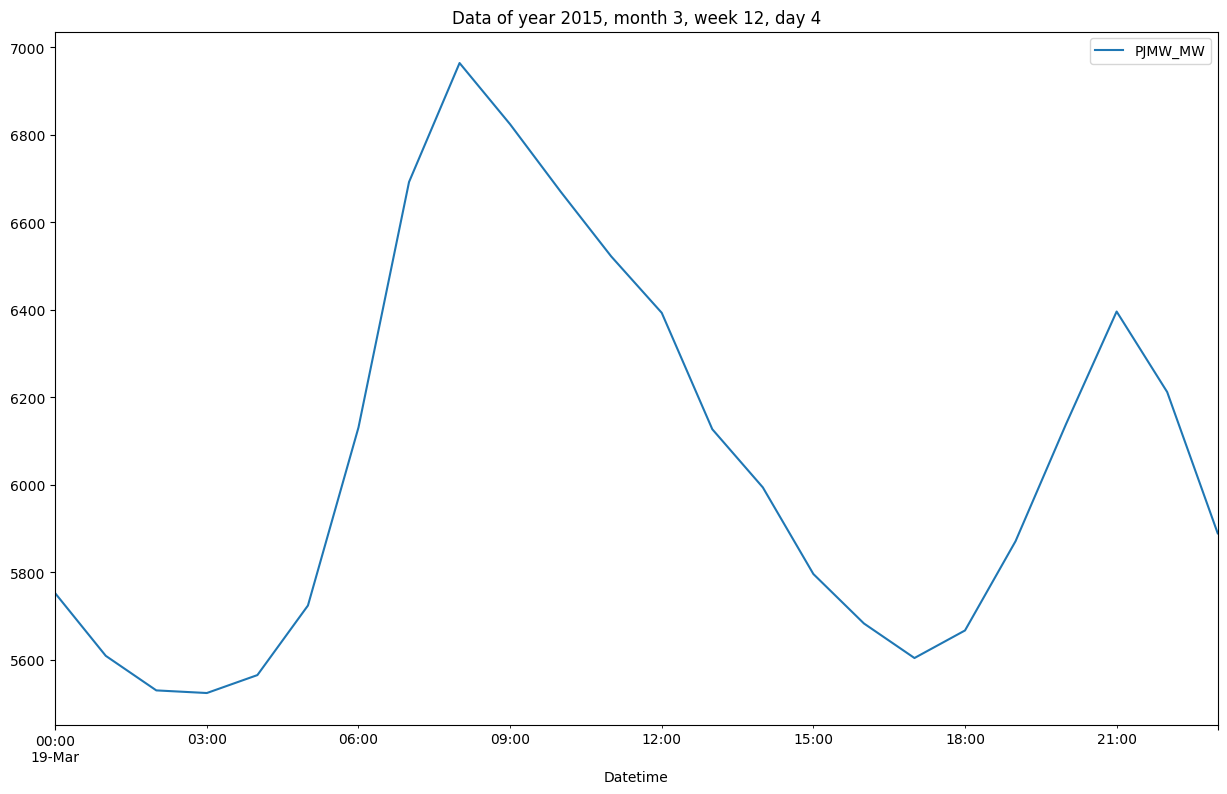

In [7]:
plot_consumption(2015,3,12,4)

In [8]:
#Adjoining information to datapoints
df['date'] = df.index.date
df['year'] = df.index.year
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['dom'] = df.index.day
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['weekday'] = df.index.day_name()
df['week'] = df.index.isocalendar().week
df['hour'] = df.index.hour

<AxesSubplot:title={'center':'PJMW - Daily trends'}, xlabel='hour'>

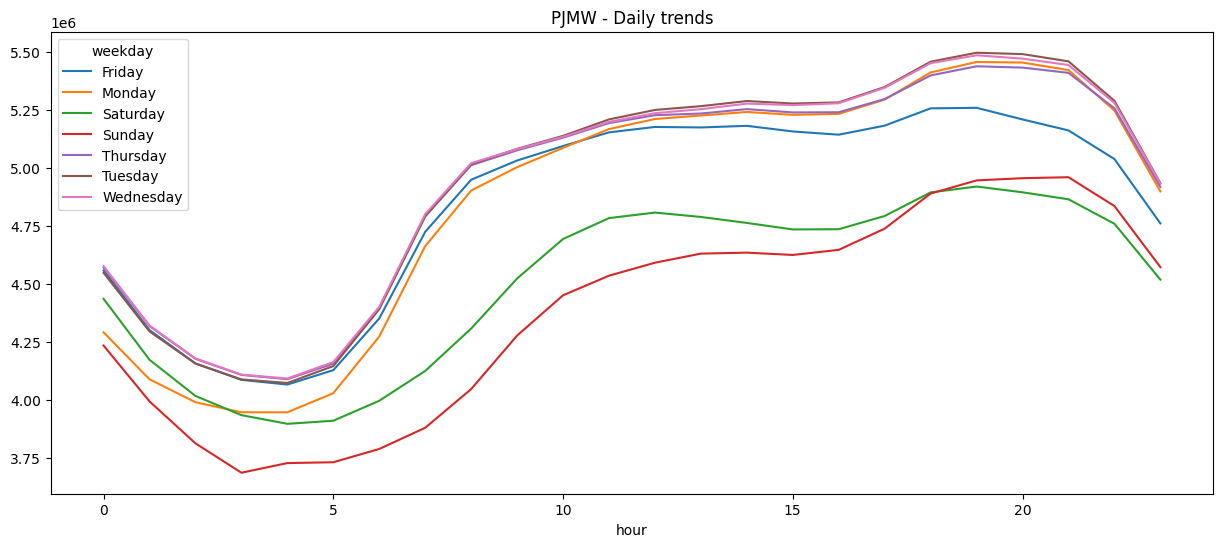

In [9]:
#Daily trends indicating less energy consumption on saturday and sunday than rest of the week
df2 = df.pivot_table(index=df['hour'],columns='weekday',values='PJMW_MW',aggfunc='sum')
df2.plot(figsize=(15,6),title='PJMW - Daily trends')

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Plotting function for seasonal/trend decomposition
def plot_STDecomp(Dataframe):
    decomposition = seasonal_decompose(Dataframe[['PJMW_MW']],period =48)
    from pylab import rcParams
    rcParams['figure.figsize'] = 12,8
    fig=decomposition.plot() 

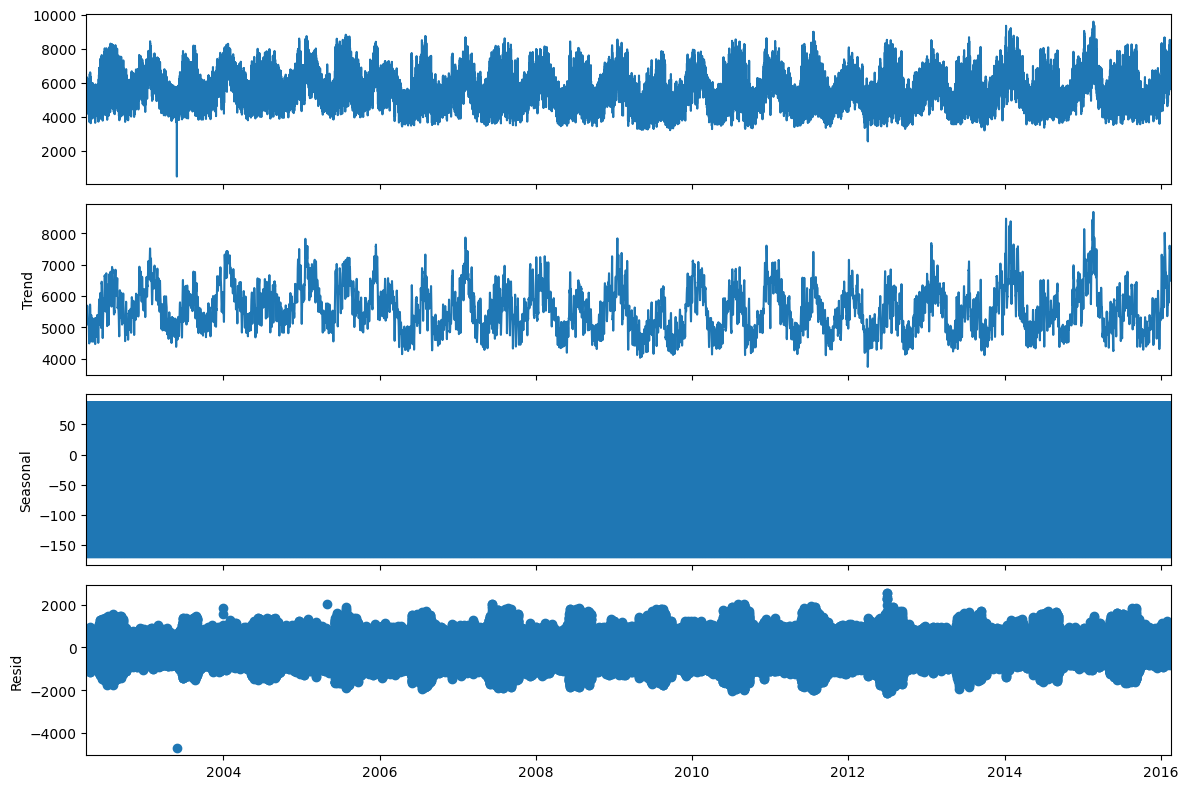

In [11]:
#Seasonal/Trend decomposition for full period 2001-2018 
plot_STDecomp(tr_df)

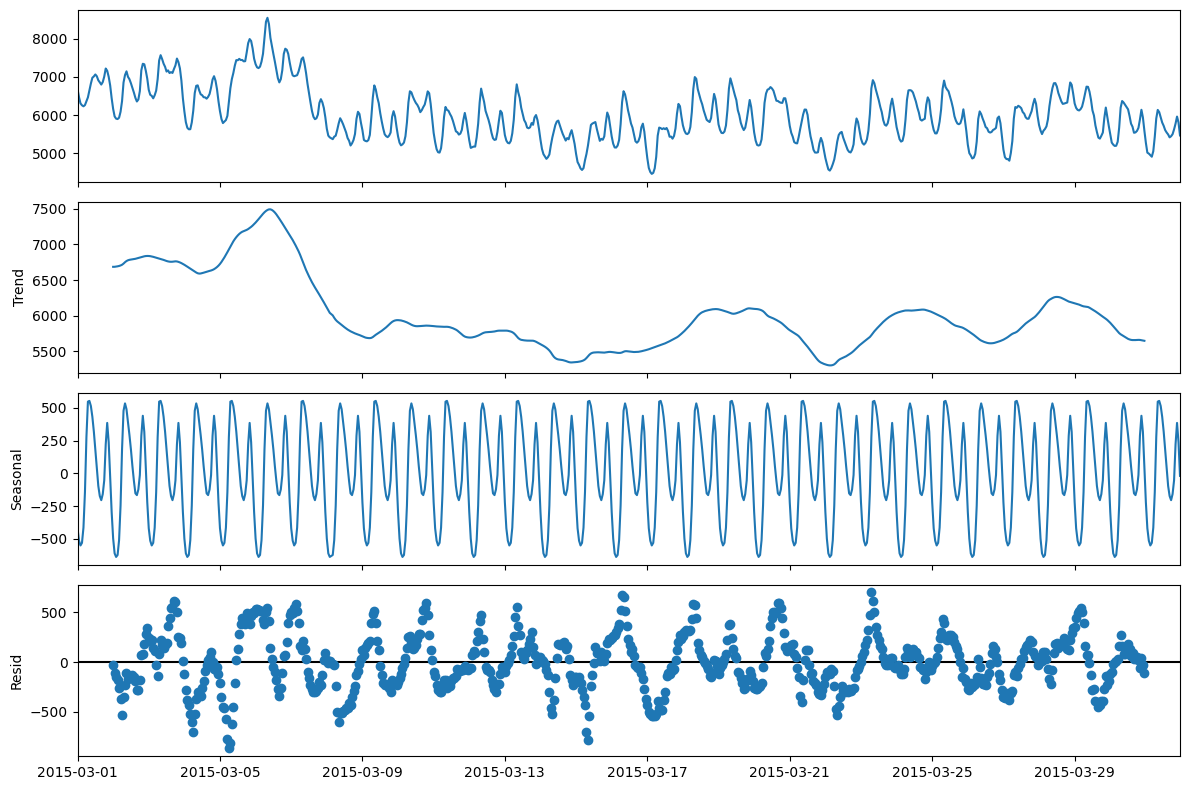

In [12]:
#Seasonal/Trend decomposition for March 2015
plot_STDecomp(tr_df.loc[(tr_df.index.year == 2015) & (tr_df.index.month == 3)])

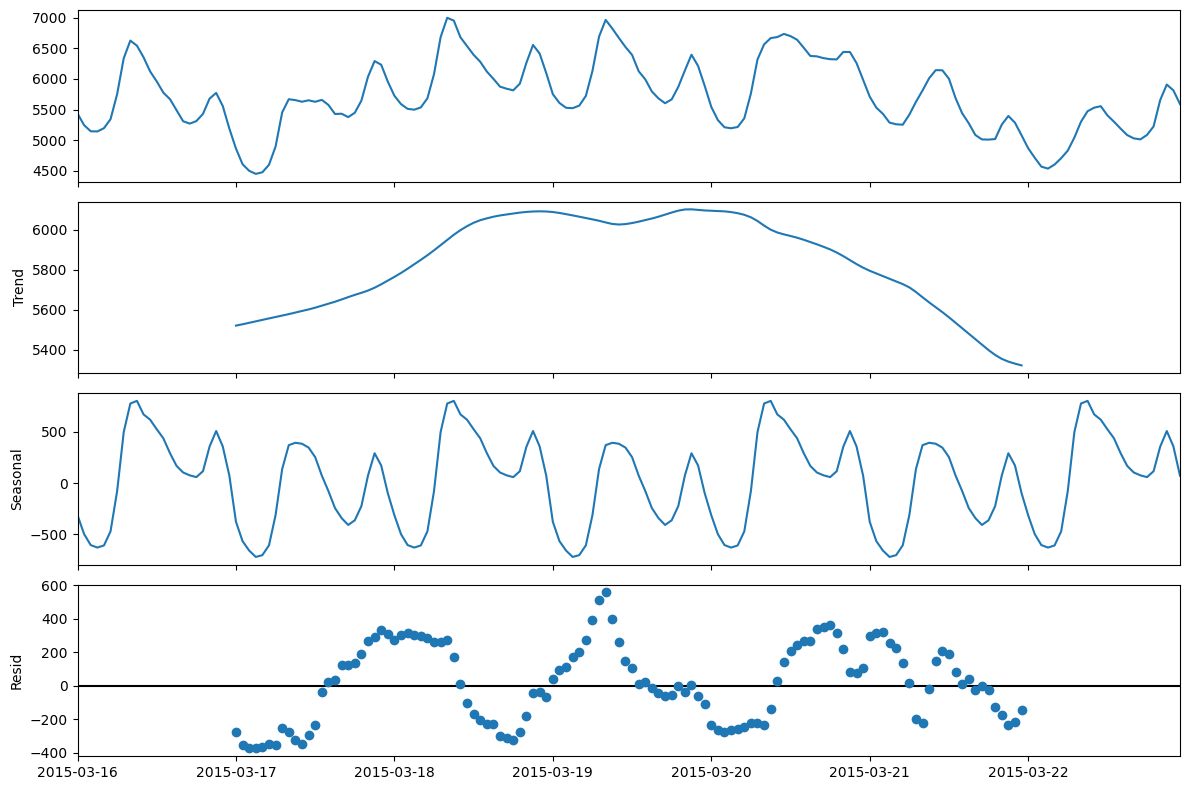

In [13]:
#Seasonal/Trend decomposition for week 12 in March 2015 
plot_STDecomp(tr_df.loc[(tr_df.index.year == 2015) & (tr_df.index.month == 3) & (tr_df.index.isocalendar().week == 12)])

In [7]:
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#adfuller tests for stationarity of datapoints, acf gives indication of value of q in ARIMA model, pacf for p.

In [15]:
#adfTest = adfuller((tr_df)['PJMW_MW'],autolag='AIC') #Too large dataset
adfTest = adfuller((tr_df.loc[tr_df.index.year >= 2014])['PJMW_MW'],autolag='AIC')
#Possibly use differences of consumption datapoints to obtain stationarity in case of full dataset

In [16]:
#p-value of adfuller test. If <0.05 then stationarity cannot be rejected.
adfTest[1]

5.719506841180672e-11

In [ ]:
#This cell would be used if pmdarima was available in jupyter lite.

#import time
#from pmdarima import auto_arima
#start=time.time()
#tr_df,te_df,df=get_train_test(freq='1M')
#model = auto_arima(tr_df,m=12,trace=True,njobs=-1)
#print(model)
#print("total time taken = {}".format(time.time()-start))

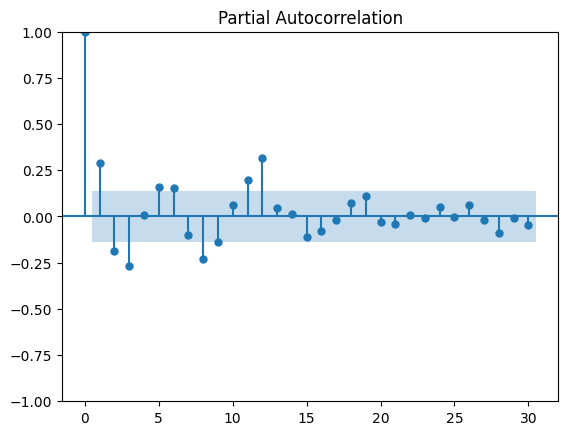

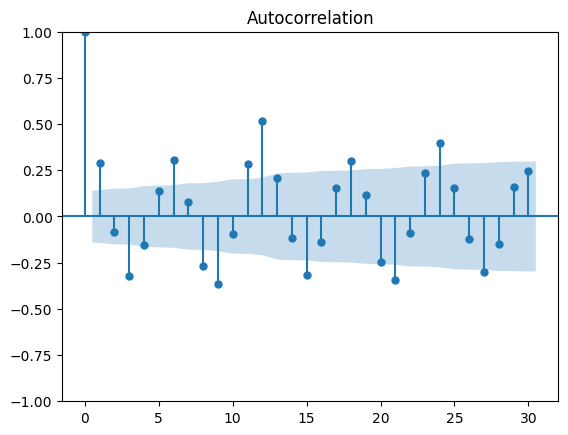

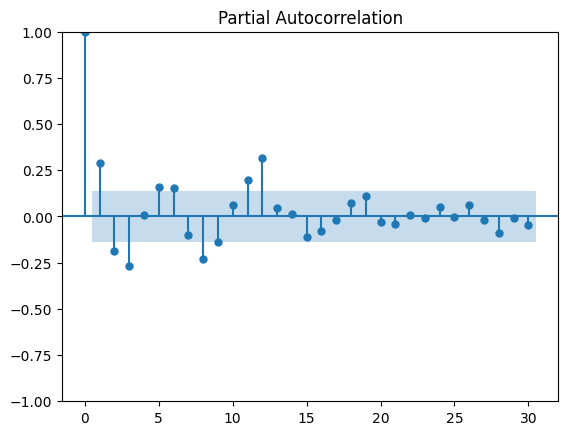

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Defining training, test and "full" dataset, when datapoints of any month is collected to 1 datapoint by summation
tr_df,te_df,m_df=get_train_test(freq='1M') #Have to collect datapoints, since dataset is too large.
plot_acf(m_df['PJMW_MW'],lags=30)
plot_pacf(m_df['PJMW_MW'],lags=30) 

In [1]:
from sklearn.metrics import mean_squared_error

In [10]:
from pylab import rcParams
#Function for choosing a SARIMA model and plotting its prediction vs test value
def my_model(p,d,q):
    model = SARIMAX(tr_df['PJMW_MW'],order=(p,d,q),seasonal_order=(p,d,q,12))
    model_fit = model.fit()
    prediction = model_fit.predict(start=te_df.index[0],end=te_df.index[-1])

    rcParams['figure.figsize'] = 16,6
    tr_df['PJMW_MW'].plot(label='Train',legend=True,linewidth=1)
    te_df['PJMW_MW'].plot(label='Test',legend=True,linewidth=1)
    prediction.plot(label='Sarimax',legend=True,linewidth=1)

    plt.show()
    print(np.sqrt(mean_squared_error(te_df['PJMW_MW'],prediction)))

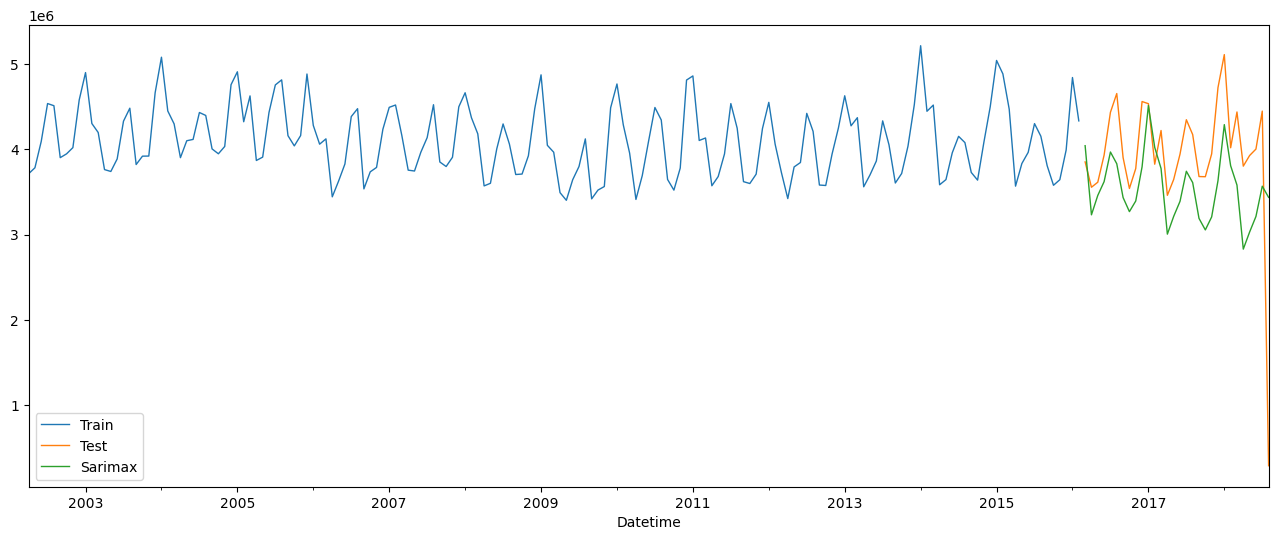

830656.4530380757


In [11]:
#p,d,q=1 is the best fit for very small values of p,d,q (maximum one of these is >1), when comparing by RMSE.
#For larger values my computer does not have enough power.
my_model(1,1,1)